In [1]:
import numpy as np
import pandas as pd
import os, sys

import json

import urllib.parse
from urllib.parse import unquote
from urllib.parse import urlparse

# Version IV

## BagOfWord for XGBoost

### Загружаем данные

In [2]:
#Параметры вычислений
file_path = '~/project/footprints.csv'
file_limit = None

In [3]:
%%time
# Загружаем файл Сибираем признаки в один мешок
theUserCorpus = pd.read_csv(file_path, sep=',', nrows=file_limit  )
theUserCorpus['subject'] = theUserCorpus[['subject', 'subject1']].agg(' '.join, axis=1)
theUserCorpus.drop(['domain', 'footprint', 'subject1'], axis=1, inplace=True )
theUserCorpus = theUserCorpus.groupby(['uid', 'age', 'gender'], as_index = False ).agg({'subject':' '.join})#transform(lambda x: ','.join(x))
theUserCorpus.head()

CPU times: user 2min 13s, sys: 4.05 s, total: 2min 17s
Wall time: 2min 13s


In [4]:
theUserCorpus.head()

,uid,age,gender,subject
0,0000e7ca-32e6-4bef-bdca-e21c025071ff,-,-,прочее прочее прочее прочее прочее прочее пту ...
1,0000f3cf-6e9a-4eab-92f4-cefdad108c83,-,-,справочные ресурсы прочее прочее прочее прочее...
2,000381a6-0400-40f8-98c0-93a6c0852d2d,-,-,домашнее хозяйство прочее домашнее хозяйство п...
3,00062d89-a3ba-40dd-9a25-212c9f429133,-,-,прочее прочее прочее прочее прочее прочее проч...
4,0009233e-a0c2-438e-ac36-bd3e1b7dad1e,-,-,прочее прочее прочее прочее прочее прочее проч...


In [5]:
#формируем мега признак
theUserCorpus['target'] = theUserCorpus.gender+theUserCorpus.age
theUserCorpus.drop(['gender', 'age'], axis=1, inplace=True )
theUserCorpus.set_index(['uid'], inplace=True)


In [6]:
#Создаем карту групп признаков: где чего лежит
theTargetName = sorted(theUserCorpus.target.unique())
theTargetMap = pd.DataFrame( {'code':range(0, len(theTargetName)) }, index = theTargetName )

In [7]:
#Генерируем номера групп согластно карте признаков
theUserCorpus['targetID'] = theUserCorpus['target'].apply( lambda x:  theTargetMap.code.loc[x] )
theUserCorpus.drop(['target'], axis=1, inplace=True )
theUserCorpus.sort_values(by=['targetID'], inplace=True)

In [8]:
#Рассчитываем положения их смещения в общем массиве
theTargetMap['len'] = theTargetMap['code'].apply( lambda type:  len(theUserCorpus[theUserCorpus.targetID == type]) )
theTargetMap['begin'] = [theTargetMap[theTargetMap.code < type ]['len'].sum() \
                        if type > 0 else 0 \
                        for type in range(0, 11) ]
theTargetMap['end'] = [theTargetMap[theTargetMap.code <= type ]['len'].sum() \
                        if type > 0 else int(theTargetMap[theTargetMap.code == type ]['len']) \
                        for type in range(0, 11) ]

In [9]:
#Эта тупая тварь не сохраняет в файл индексы. Ставим заплатку
theUserCorpus.reset_index(inplace=True)
theUserCorpus.to_csv('~/project/corpus.csv', sep=',', index=False)
theTargetMap.to_csv('~/project/corpus_map.csv', sep=',', index=False)
theUserCorpus.set_index(['uid'], inplace=True)

### Любуемся результатом

In [10]:
theTargetMap

,code,len,begin,end
--,0,5000,0,5000
F18-24,1,2886,5000,7886
F25-34,2,6791,7886,14677
F35-44,3,4271,14677,18948
F45-54,4,2597,18948,21545
F>=55,5,895,21545,22440
M18-24,6,2012,22440,24452
M25-34,7,8666,24452,33118
M35-44,8,5089,33118,38207
M45-54,9,2147,38207,40354


In [11]:
theUserCorpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41138 entries, 0000e7ca-32e6-4bef-bdca-e21c025071ff to 0d32fbfe-c241-4ac0-9d60-1fb9f4e2dea3
Data columns (total 2 columns):
subject     41138 non-null object
targetID    41138 non-null int64
dtypes: int64(1), object(1)
memory usage: 964.2+ KB


In [12]:
theUserCorpus.head()

,subject,targetID
uid,,
0000e7ca-32e6-4bef-bdca-e21c025071ff,прочее прочее прочее прочее прочее прочее пту ...,0
50506a7f-f9e5-48d5-9590-9667f4d6ee9c,торговля прочее здоровье красота здоровье крас...,0
505240e6-f540-4154-a35b-dcdbaf354dc4,новости и сми бизнес новости и сми бизнес ново...,0
50528c7d-805f-4f73-9625-20ba0f9ce3b3,прочее прочее прочее прочее прочее прочее проч...,0
5053e3ad-47e0-47e5-97b4-1e62c7c603d6,прочее прочее,0


### Запихиваем данные в мешок

In [126]:
#Собираем корпус
theCorpus = list(theUserCorpus['subject'])
print ('Size of theCorpus is ', len(theCorpus) )

Size of theCorpus is  41138


In [153]:
%%time
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

#Процедура токенизации
def tokenise( text ):
    words = [word.lower() for word in word_tokenize(text)]
    return words

#stopsWords = ['неизвестный']
#Обучаем векторизатор и генерируем Bag of Words
theVectorizer = CountVectorizer(tokenizer=tokenise) #, stop_words= stopsWords
theBagOfWords = theVectorizer.fit_transform(theCorpus).toarray()

CPU times: user 1min 55s, sys: 8 ms, total: 1min 55s
Wall time: 2min 7s


In [154]:
"""
from sklearn.feature_extraction.text import TfidfVectorizer
# Создать матрицу признаков на основе меры tf-idf
tfidf = TfidfVectorizer(use_idf=False)
theBagOfWords = tfidf.fit_transform( theCorpus )
theBagOfWords.shape
"""

'\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n# Создать матрицу признаков на основе меры tf-idf\ntfidf = TfidfVectorizer(use_idf=False)\ntheBagOfWords = tfidf.fit_transform( theCorpus )\ntheBagOfWords.shape\n'

In [156]:
theBagOfWords = np.delete(theBagOfWords, [1, 2, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29,
                                          30, 31, 32, 33, 34, 35, 36, 38, 41, 42, 44, 45, 47, 48, 49,
                                         51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 
                                         71, 73, 75, 76, 77], axis=1)
#theBagOfWords = np.delete(theBagOfWords, [45, 47, 51], axis=1)

#theBagOfWords = np.delete(theBagOfWords, [8, 13, 16, 17, 27, 28, 30, 36, 38, 40, 42, 45, 46, 51, 52, 56, 57, 62, 63, 64, 65, 67, 69, 75], axis=1)

theBagOfWords.shape

(41138, 18)

### Выделяем диапазон для исследований

In [157]:
partSize = 41138
fullData = theBagOfWords[5000:41138]
fullTarget = (theUserCorpus['targetID'].values)[5000:41138]
fullData.shape, fullTarget.shape 

((36138, 18), (36138,))

### Загоняем в xgboost

In [158]:
%%time
from sklearn.model_selection import train_test_split
#Делим мастер данные на массивы
masterData, researchmentData, masterTarget, researchmentTarget = \
    train_test_split(fullData, fullTarget, test_size= 0.33, random_state=33 )

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 48.6 ms


In [159]:
%%time
import xgboost

# У кого xgboost длиннее тот и прав
model = xgboost.XGBRegressor(n_estimators = 200, nthread= -1, max_depth = 6, objective = 'multi:softmax', num_class = 11 ) #
history = model.fit(masterData, masterTarget)

CPU times: user 11min 24s, sys: 1min 44s, total: 13min 8s
Wall time: 55.6 s


In [160]:
len(model.feature_importances_), model.feature_importances_

(18, array([0.02312053, 0.03164819, 0.02946669, 0.05771042, 0.03920078,
        0.04148143, 0.09881175, 0.06579187, 0.03417673, 0.01725363,
        0.07025401, 0.09639888, 0.16470277, 0.04110133, 0.0400271 ,
        0.04126659, 0.07501364, 0.03257367], dtype=float32))

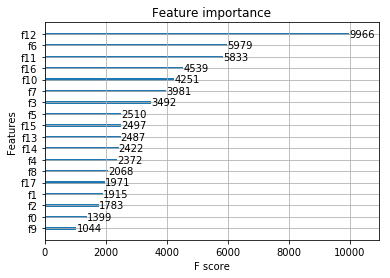

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance

plot_importance(model, max_num_features=18) # top 10 most important features
plt.show()

In [162]:
#
from sklearn.metrics import accuracy_score
researchmentLabel = model.predict(researchmentData)
researchmentPredict = model.predict(theBagOfWords[:5000])
#researchmentProbability = model.predict_proba(theBagOfWords[:5000])

print("Score: %.2f%%" % (model.score(masterData, masterTarget) * 100.0) )
print("Accuracy: %.2f%%" % (accuracy_score(researchmentTarget, researchmentLabel) * 100.0) )

Score: -26.19%
Accuracy: 25.93%


In [163]:
from sklearn.metrics import classification_report
report = classification_report(researchmentTarget, researchmentLabel, target_names=list(theTargetMap.index[1:])) #['...', '...']
print(report)

              precision    recall  f1-score   support

      F18-24       0.18      0.02      0.04       986
      F25-34       0.23      0.54      0.32      2195
      F35-44       0.24      0.08      0.12      1408
      F45-54       0.11      0.02      0.03       797
       F>=55       0.00      0.00      0.00       305
      M18-24       0.04      0.00      0.00       663
      M25-34       0.30      0.53      0.39      2897
      M35-44       0.25      0.13      0.17      1699
      M45-54       0.12      0.02      0.03       707
       M>=55       0.18      0.01      0.01       269

    accuracy                           0.26     11926
   macro avg       0.16      0.13      0.11     11926
weighted avg       0.21      0.26      0.20     11926



In [164]:
researchmentPredict

array([2., 2., 7., ..., 2., 2., 2.], dtype=float32)